# Projeto: Análise de Sentimentos em Redes Sociais
## Etapa: Modelagem
**Autor:** Vinícius Ramos  
**Fonte do Dataset:** [Kaggle](https://www.kaggle.com/datasets/kashishparmar02/social-media-sentiments-analysis-dataset)

## 1. Importação das Bibliotecas

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# Baixar recursos do NLTK (se necessário)
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\viras\AppData\Roaming\nltk_data...


## 2. Carregamento dos Dados Processados

In [3]:
df = pd.read_csv('../data/processed/sentimentdataset_tratado.csv')

In [4]:
# Verificar se há valores nulos na coluna de texto e removê-los se houver
df.dropna(subset=['Text'], inplace=True)

In [6]:
df.shape


(732, 14)

In [7]:
df['Sentiment_Simplified'].value_counts()

Sentiment_Simplified
Positivo    356
Neutro      219
Negativo    157
Name: count, dtype: int64

## 3. Pré-processamento de Texto (Função de Limpeza)

In [ ]:
# Lista de stopwords do inglês
stop_words = set(stopwords.words('english'))
# Adicionando a palavra 'like' que foi identificada como ruído na EDA
stop_words.add('like')

In [10]:
# Inicializando o Lematizador (reduz palavras à sua forma base, ex: 'running' -> 'run')
lemmatizer = WordNetLemmatizer()

In [14]:

def preprocess_text(text):
    # 1. Converter para minúsculas
    text = text.lower()
    # 2. Remover URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # 3. Remover menções (@) e hashtags (#)
    text = re.sub(r'\@\w+|\#','', text)
    # 4. Remover pontuação e números
    text = re.sub(r'[^a-z\s]', '', text)
    # 5. Tokenização (dividir o texto em palavras) e remoção de stopwords
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    # 6. Lematização
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # 7. Juntar os tokens de volta em uma string
    return " ".join(tokens)

df['Text_Processed'] = df['Text'].apply(preprocess_text)

## 4. Divisão dos Dados (Treino e Teste)

In [15]:
# Features
X = df['Text_Processed']
# Target
y = df['Sentiment_Simplified']

In [18]:
# Divisão dos Dados (Treino e Teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [22]:
len(X_train), len(X_test), len(y_train), len(y_test)

(585, 147, 585, 147)

## 5. Criação do Pipeline de Modelagem

In [23]:
# Pipeline 1: Regressão Logística (nosso modelo base)
pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('classifier', LogisticRegression(random_state=42, multi_class='ovr', solver='liblinear'))
    ])

# Pipeline 2: Random Forest
pipeline_rf = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)) # n_jobs=-1 usa todos os cores do processador
])

## 6. Treinamento dos Modelos

In [25]:
# Treinamento do modelo de Regressão Logística
pipeline_lr.fit(X_train, y_train)

c:\Users\viras\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
                ('classifier',
                 LogisticRegression(multi_class='ovr', random_state=42,
                                    solver='liblinear'))])

In [26]:
# Treinamento do modelo de Random Forest
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
                ('classifier',
                 RandomForestClassifier(n_jobs=-1, random_state=42))])

## 7. Avaliação Comparativa dos Modelos

In [31]:
y_pred_lr = pipeline_lr.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
accuracy_lr

0.6190476190476191

In [32]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

    Negativo       0.89      0.25      0.39        32
      Neutro       0.87      0.30      0.44        44
    Positivo       0.57      0.99      0.72        71

    accuracy                           0.62       147
   macro avg       0.77      0.51      0.52       147
weighted avg       0.73      0.62      0.57       147



In [33]:
y_pred_rf = pipeline_rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_rf

0.6258503401360545

In [35]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

    Negativo       0.75      0.38      0.50        32
      Neutro       0.85      0.25      0.39        44
    Positivo       0.58      0.97      0.73        71

    accuracy                           0.63       147
   macro avg       0.73      0.53      0.54       147
weighted avg       0.70      0.63      0.58       147



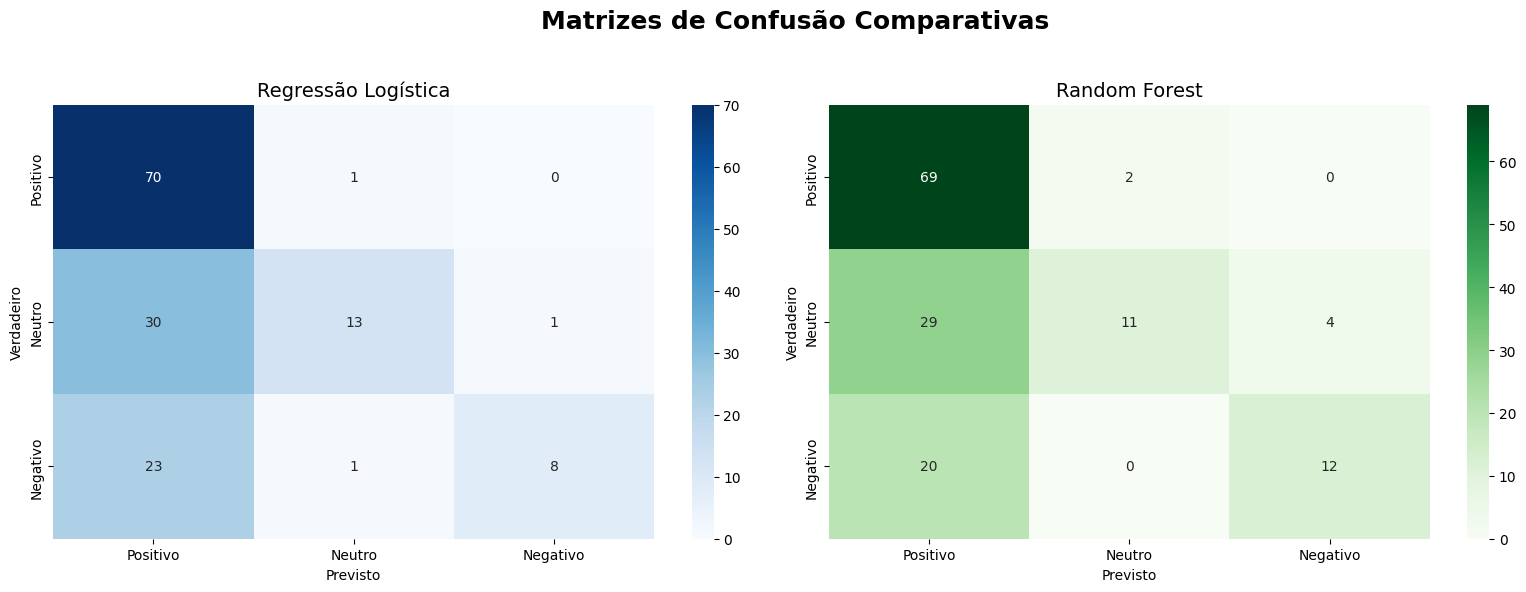

In [36]:
# Matrizes de Confusão Lado a Lado
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
labels = ['Positivo', 'Neutro', 'Negativo']

# Matriz para Regressão Logística
cm_lr = confusion_matrix(y_test, y_pred_lr, labels=labels)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=labels, yticklabels=labels)
axes[0].set_title('Regressão Logística', fontsize=14)
axes[0].set_ylabel('Verdadeiro')
axes[0].set_xlabel('Previsto')

# Matriz para Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=labels)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=labels, yticklabels=labels)
axes[1].set_title('Random Forest', fontsize=14)
axes[1].set_ylabel('Verdadeiro')
axes[1].set_xlabel('Previsto')

plt.suptitle('Matrizes de Confusão Comparativas', fontsize=18, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
